# Run Immediately

## Libraries

In [1]:
%pip install keras tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Normal Lib
import os
import pandas as pd
import numpy as np
import random
from typing import cast
import csv
import matplotlib.pyplot as plt
from sklearn import metrics

In [4]:
# keras
from keras import Model
from keras.layers import Conv3D, Input, MaxPooling3D, BatchNormalization, Dense, Dropout, Flatten,Activation, GlobalAveragePooling3D
import tensorflow as tf
from keras.optimizers import Adam
import keras

2024-05-10 01:47:39.615403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 01:47:40.531588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# Metrics
from scipy.stats import pearsonr, spearmanr # Pearson R best
from keras.metrics import MeanAbsoluteError
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
from rdkit import Chem

In [7]:
from utils.preprocessing import get_atom_features, get_min

In [8]:
# Get the current working directory
cwd = os.getcwd()
print(cwd)

/home/jovyan/work/ligand-protein-tay-chan-mieng/Code


Set constants

In [30]:
# save_path1 = './Save'
# best_path1 = './Best'
model_type1 = "SFCNN"
csv_path1_100 = './SFCNN/Report/resultSFCNN100.csv'
csv_path1_500 = './SFCNN/Report/resultSFCNN500.csv'
csv_path1_2000 = './SFCNN/Report/resultSFCNN2000.csv'

sfcnn_save_path = './SFCNN/Save'
sfcnn_best_path = './SFCNN/Best'

model_type2 = "3DCNN"

csv_path2_100 = './3DCNN/Report/result3DCNN100.csv'
csv_path2_500 = './3DCNN/Report/result3DCNN500.csv'
csv_path2_2000 = './3DCNN/Report/result3DCNN2000.csv'
_3dcnn_save_path = './3DCNN/Save'
_3dcnn_best_path = './3DCNN/Best'

test_save_path = './test/Save'
test_best_path = './test/Best'
csv_path3_100 = './test/Report/result3DCNN100.csv'
csv_path3_500 = './test/Report/result3DCNN500.csv'
csv_path3_2000 = './test/Report/result3DCNN2000.csv'

## Classes

In [10]:
def addNotUnique(nuC, uCL):
  x,y,z = nuC

  tmp1 = (x+1, y, z)
  if tmp1 not in uCL:
    uCL.append(tmp1)
    return tmp1

  tmp2 = (x, y+1, z)
  if tmp2 not in uCL:
    uCL.append(tmp2)
    return tmp2

  tmp3 = (x, y, z+1)
  if tmp3 not in uCL:
    uCL.append(tmp3)
    return tmp3

  tmp4 = (x+1, y+1, z)
  if tmp4 not in uCL:
    uCL.append(tmp4)
    return tmp4

  tmp5 = (x+1, y, z+1)
  if tmp5 not in uCL:
    uCL.append(tmp5)
    return tmp5

  tmp6 = (x, y+1, z+1)
  if tmp6 not in uCL:
    uCL.append(tmp6)
    return tmp6

  tmp7 = (x+1, y+1, z+1)
  if tmp7 not in uCL:
    uCL.append(tmp7)
    return tmp7

  tmp8 = (x-1, y, z)
  if tmp8 not in uCL:
    uCL.append(tmp8)
    return tmp8

  tmp9 = (x, y-1, z)
  if tmp9 not in uCL:
    uCL.append(tmp9)
    return tmp9

  tmp10 = (x, y, z-1)
  if tmp10 not in uCL:
    uCL.append(tmp10)
    return tmp10

  tmp11 = (x-1, y-1, z)
  if tmp11 not in uCL:
    uCL.append(tmp11)
    return tmp11

  tmp12 = (x-1, y, z-1)
  if tmp12 not in uCL:
    uCL.append(tmp12)
    return tmp12

  tmp13 = (x, y-1, z-1)
  if tmp13 not in uCL:
    uCL.append(tmp13)
    return tmp13

  tmp14 = (x-1, y-1, z-1)
  if tmp14 not in uCL:
    uCL.append(tmp14)
    return tmp14

In [53]:
def set_grid(protein_path, ligand_path):
    compound = Chem.MolFromPDBFile(protein_path, False, False, 1)
    compound_conf = compound.GetConformer()
    compound_positions = compound_conf.GetPositions()

    result = get_min(compound_positions)

    atoms_aa = []
    with open(protein_path, 'r+') as f:
        readlines = f.readlines()
        f.close()
    for idx, lines in enumerate(readlines):
        if 'HETATM' in lines or 'ATOM' in lines:
            atoms_aa.append(lines[17:20])

    with open(ligand_path, 'r+') as f:
        readlines = f.readlines()
        f.close()
    for idx, lines in enumerate(readlines):
        if 'HETATM' in lines or 'ATOM' in lines:
            atoms_aa.append(lines[17:20])

    uniqueCoord = []
    # repeatedCoord = []

    atom_e = compound.GetAtomWithIdx(int(1))
    features_e = get_atom_features(atom_e, '', 1)
    grid=np.zeros((52,52,52,len(features_e)+3))
    # print(np.shape(grid))

    for idx, coords in enumerate(compound_positions):
      amino_acid = atoms_aa[idx]
      atom = compound.GetAtomWithIdx(int(idx))
      features = get_atom_features(atom, amino_acid, 1)
      features.extend([coords[0],coords[1],coords[2]])

      x= coords[0] - (result[0] - 1)
      y= coords[1] - (result[1] - 1)
      z= coords[2] - (result[2] - 1)
      roundx = round(x)
      roundy = round(y)
      roundz = round(z)
      checkCoords = (roundx, roundy, roundz)

      if checkCoords not in uniqueCoord:
        uniqueCoord.append(checkCoords)
        grid[roundx, roundy, roundz] = features
      else:

        tmpCoord = addNotUnique(checkCoords, uniqueCoord)
        grid[tmpCoord[0], tmpCoord[1], tmpCoord[2]] = features

    con_com = len(compound_positions)
    compound = Chem.MolFromPDBFile(ligand_path, False, False, 1)
    compound_conf = compound.GetConformer()
    compound_positions = compound_conf.GetPositions()

    for idx, coords in enumerate(compound_positions):
      amino_acid = atoms_aa[idx+con_com]
      atom = compound.GetAtomWithIdx(int(idx))
      features = get_atom_features(atom, amino_acid, 0)
      features.extend([coords[0],coords[1],coords[2]])

      x= coords[0] - (result[0])
      y= coords[1] - (result[1])
      z= coords[2] - (result[2])
      roundx = round(x)
      roundy = round(y)
      roundz = round(z)
      checkCoords = (roundx, roundy, roundz)

      if checkCoords not in uniqueCoord:
        uniqueCoord.append(checkCoords)
        grid[roundx, roundy, roundz] = features
      else:

        tmpCoord = addNotUnique(checkCoords, uniqueCoord)
        grid[tmpCoord[0], tmpCoord[1], tmpCoord[2]] = features


    return grid

## Get data batch

In [12]:
def get_data_batch(
    dataset_idx, 
    protein_folder, 
    ligand_folder, 
    label_folder, 
    batch_size, 
    index, 
    type_model):
  core_grids=None
  core_ba= []
  core_stat= []
  # List all files and directories in the dataset folder
  ligand_list = os.listdir(ligand_folder)
  protein_list = os.listdir(protein_folder)
  label_list = os.listdir(label_folder)

  # Get the batch list by index
  batch_list = [value for idx, value in enumerate(dataset_idx) if idx >= index * batch_size and idx < (index+1)*batch_size ]
  if type_model == '3DCNN':
    for i in batch_list:
      # Read all the files in ligand_folder as a list
      # Feature = gridFromCenter()
      complexFile = ligand_list[i]

      # Get Data and Labels
      ## Get the protein name from the complex file, ex: 3qzq-8v_model1.pdb -> 3qzq
      from_protein = complexFile.split('-')[0]
      # Get the complex name from the complex file, ex: 3qzq-8v_model1.pdb -> 3qzq-8v_model1
      complex_name = complexFile.split('.')[0]
      # Get the path to all .pdb files in protein folder
      protein_path = os.path.join(protein_folder, from_protein+'.pdb')
      complexFile_path = os.path.join(ligand_folder, complexFile)

      # grid, minx, miny, minz = set_grid(protein_path)
      # grid = add_ligand(complexFile_path, grid, minx, miny, minz)
      grid = set_grid(protein_path, complexFile_path)
      if core_grids is None:
          core_grids = []
      core_grids.append(grid)
      grid = []

      protein = [value for value in label_list if from_protein in value][0]
      label_file_path = os.path.join(label_folder, protein)

      df = pd.read_csv(label_file_path)
      listidx = df.index[df['file.pdb'] == complex_name].tolist()[0]
      ba = df['BA'][listidx]
      stat = df['Hit/No_hit'][listidx]
      if stat == 'hit':
        stat = 1
      else:
        stat = 0
      core_ba.append(ba)
      core_stat.append(stat)

    core_grids = np.array(core_grids)
    core_ba = np.array(core_ba)
    core_stat = np.array(core_stat)

    return core_grids, core_ba, core_stat


  if type_model == 'SFCNN':
    Feature = Feature_extractor()
    for id in batch_list:
      # if cur_batch*batch_size >=
      ligand_name = ligand_list[id]
      ligand_train_path = os.path.join(ligand_folder, ligand_name)
      # print(ligand_name)
      protein_name1 = ligand_name.split('-')[0]
      protein_name2 = protein_name1
      complex_name = ligand_name.split('.')[0]
      for name in protein_list:
        if protein_name1 in name:
          protein_name1 = name
          continue
      # print(protein_folder)
      protein_train_path = os.path.join(protein_folder, protein_name1)

      protein = Chem.MolFromPDBFile(protein_train_path, False, False, 0)
      ligand = Chem.MolFromPDBFile(ligand_train_path, False, False, 0)
      # train_complexes.append((protein, ligand))
      coords1, features1 = Feature.get_features(protein,1)
      coords2, features2 = Feature.get_features(ligand,0)
      protein = None
      ligand = None
      center=(np.max(coords2,axis=0)+np.min(coords2,axis=0))/2
      coords=np.concatenate([coords1,coords2],axis = 0)
      features=np.concatenate([features1,features2],axis = 0)
      assert len(coords) == len(features)
      coords = coords-center
      grid=Feature.grid(coords,features, rotations=0)
      if core_grids is None:
          core_grids = grid
      else:
          core_grids = np.concatenate([core_grids,grid],axis = 0)
      grid = []

      label_list = os.listdir(label_folder)
      for name in label_list:
        if protein_name2 in name:
          protein_name2 = name
          continue
      label_train_path = os.path.join(label_folder, protein_name2)
      df = pd.read_csv(label_train_path)
      listidx = df.index[df['file.pdb'] == complex_name].tolist()[0]
      ba = df['BA'][listidx]
      stat = df['Hit/No_hit'][listidx]
      if stat == 'hit':
        stat = 1
      else:
        stat = 0

      core_ba.append(ba)
      core_stat.append(stat)

    core_ba = np.array(core_ba)
    core_stat = np.array(core_stat)
    return core_grids, core_ba, core_stat



## Other functions

In [38]:
def model_train(model, train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model):
  dataset_len = len(train_dataset_idx)
  runs = dataset_len // batch_size
  cur = 1
  log_txt = "log.txt"
  log_path = os.path.join(save_path, log_txt)
  readline = ''
  if os.path.exists(log_path):
    log_file = open(log_path,"r+")
    readline = log_file.readline()
    log_file.close()
  else:
    with open(log_path, 'w+') as f:
      f.write('0/'+str(runs))
      f.close()

  if readline == '' or int(readline.split('/')[0]) > runs or int(readline.split('/')[0]) == 0:
    cur = 1
    model.save(save_path + '.keras')
  else:
    cur = int(readline.split('/')[0])
  check = 0

  print("----------------------- Start TrainDataset ------------------------")
  for i in range(int(cur-1),int(runs)):
    print("=======================Batch "+ str(i+1)+"==============================")
    model = keras.models.load_model(save_path + '.keras')
    print("Get dataset")
    gridList, baList, statList = get_data_batch(train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, i, type_model)
    print("----------------------- Train TrainDataset ------------------------")
    model.fit(gridList, [baList, statList], epochs= epochs,verbose=0)
    gridList, baList, statList = [], [], []
    # PearsonR, MSE, RMSE, precision, recall, auc, f1_score, MCC = model_val_dataset(val_dataset_idx, protein_folder, label_folder, label_list, batch_size, epochs, save_path, best_path)
    print("Save")
    model.save(save_path + '.keras')
    log_file = open(log_path,"r+")
    readline = log_file.write(str(i)+'/'+str(runs))
    log_file.close()
    # if PearsonR > checkPearsonR and MCC > checkMCC and RMSE < checkRMSE:
    #   model.save(best_path)
    #   checkPearsonR = PearsonR
    #   checkMCC = MCC
    #   checkRMSE = RMSE
    if check == 0 and batch_size*i >= 2000:
      check +=1
      model.save(best_path + '.keras')
    print("======================= End Batch "+ str(i+1)+"==============================")
  return model

In [14]:
def SFCNN_model(input_shape=(20,20,20,28)):
  inp = Input(shape= input_shape, name='Input_Complexes')

  # Classification

  ## Check there are atoms
  x1 = Conv3D(7,kernel_size=(1,1,1),strides=(1,1,1))(inp)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(7,kernel_size=(3,3,3))(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  # x1 = AveragePooling3D(padding='same')(x1)

  x1 = Conv3D(56,kernel_size=(3,3,3),padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x1 = MaxPooling3D(pool_size=2)(x1)

  x1 = Conv3D(112,kernel_size=(3,3,3),padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x1 = MaxPooling3D(pool_size=2)(x1)

  x1 = Conv3D(224,kernel_size=(3,3,3),padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x1 = MaxPooling3D(pool_size=2)(x1)

  # Global Pooling
  x2 = GlobalAveragePooling3D()(x1)

  x2 = Dense(256)(x2)
  x2 = BatchNormalization()(x2)
  x2 = Activation('relu')(x2)
  x2 = Dropout(0.5)(x2)

  # Flattening
  x1 = Flatten()(x1)

  x1 = Dense(256)(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x1 = Dropout(0.5)(x1)

  # Regression Output
  d1 = Dense(1,kernel_regularizer=tf.keras.regularizers.l2(0.01))(x1)
  # Classification Output
  d2 = Dense(1, activation='sigmoid')(x2)

  return Model(inputs=[inp], outputs=[d1,d2], name='Embedding')

In [15]:
def CNN_model(drop_rate, input_shape= (52,52,52,14)):
  inp = Input(shape= input_shape, name='Input_Complexes')

  ## Check there are atoms
  ## Sketch the pattern of the whole biomolecule
  x1 = Conv3D(filters= 32, kernel_size=(1,1,1),strides=(1,1,1) ,padding='same', bias_initializer='zeros', kernel_initializer='glorot_uniform')(inp)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 8, kernel_size=2, padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 8, kernel_size=3,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = MaxPooling3D(pool_size=2)(x1)

  ## Find pattern for chunk size

  x1 = Conv3D(filters= 128,kernel_size=(1,1,1),padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 64,kernel_size=2,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 64,kernel_size=3,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = MaxPooling3D(pool_size=2)(x1)

  ## Find pattern for amino acid size
  x1 = Conv3D(filters= 256,kernel_size=(1,1,1),padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 128,kernel_size=2,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 128,kernel_size=3,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = MaxPooling3D(pool_size=2)(x1)

  ## Find pattern for atom interaction size
  x1 = Conv3D(filters= 512,kernel_size=(1,1,1),padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 256,kernel_size=2,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  x1 = Conv3D(filters= 256,kernel_size=3,padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  # x1 = MaxPooling3D(pool_size=2)(x1)

  #   # Global Pooling
  x2 = GlobalAveragePooling3D()(x1)

  x2 = Dense(256)(x2)
  x2 = BatchNormalization()(x2)
  x2 = Activation('relu')(x2)
  x2 = Dropout(0.5)(x2)

  # # Flattening
  x1 = Flatten()(x1)

  x1 = Dense(256)(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x1 = Dropout(0.5)(x1)

  # # Regression Output
  d1 = Dense(1,kernel_regularizer=tf.keras.regularizers.l2(0.01))(x1)
  # Classification Output
  d2 = Dense(1, activation='sigmoid')(x2)

  # return Model(inputs=[inp], outputs=[d1,d2], name='Embedding')
  return Model(inputs=[inp], outputs=[d1, d2], name='Embedding')


In [16]:
def plot_class(x, y):
  #create scatterplot with regression line
  # plt.scatter(x, y)
  # plt.show()
  # # sns.regplot(y_label, y_pred)
  new_y = []
  for value in y:
    if value >= 0.9:
      new_y.append(1)
    else:
      new_y.append(0)
  confusion_matrix = metrics.confusion_matrix(x, new_y)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Hit", "No_Hit"])

  cm_display.plot()
  plt.show()
  return cm_display

In [17]:
def plot_reg(x, y):
  #create scatterplot with regression line
  #use green as color for individual points
  X = np.array(x)
  plt.plot(x, y, 'o', color='green')

  #obtain m (slope) and b(intercept) of linear regression line
  m, b = np.polyfit(x, y, 1)


  #use red as color for regression line
  plt.plot(X, m*X+b, color='red')


In [18]:
import math

In [19]:
def get_metrics(y_label, y_pred, ytype):

  if ytype == 0: # Regression
    print("++++++++++++++++++++++++++Regression++++++++++++++++++++++++++")
    PearsonR, p1 = pearsonr(y_label, y_pred)
    print('Pearson Correlation Coefficient: ' + str(PearsonR))
    print('P value: ' + str(p1))
    MSE = MeanAbsoluteError()
    MSE.update_state(y_label, y_pred)
    MSE = MSE.result().numpy()
    print('Mean Absolute Error: ' + str(MSE))

    rms = mean_squared_error(y_label, y_pred, squared=False)
    # rms = math.sqrt(mean_squared_error(y_label, y_pred, squared=False))
    print('Root Mean Error: ' + str(rms))

    r2 =r2_score(y_label, y_pred)
    print('Correlation of Covariance: ' + str(r2))

    rho, p2 = spearmanr(y_label, y_pred)
    print('Spearman Rank Correlation Coefficient: ' + str(rho))
    print('P value: ' + str(p2))

    # plot_reg(y_label, y_pred)

    return PearsonR, p1, MSE, rms, rho, p2

  if ytype == 1: # Classification
    print("+++++++++++++++++++++++Classification+++++++++++++++++++++++")

    tp = keras.metrics.TruePositives(thresholds= 0.9)
    tn = keras.metrics.TrueNegatives(thresholds= 0.9)
    fp = keras.metrics.FalsePositives(thresholds= 0.9)
    fn = keras.metrics.FalseNegatives(thresholds= 0.9)


    tp.update_state(y_label, y_pred)
    tn.update_state(y_label, y_pred)
    fp.update_state(y_label, y_pred)
    fn.update_state(y_label, y_pred)

    tp = tp.result().numpy()
    tn = tn.result().numpy()
    fp = fp.result().numpy()
    fn = fn.result().numpy()

    precision = tp/ (tp+fp) # PPV
    print('Precision: ' + str(precision))

    recall = tp/(tp+fn) # Recall - TPR
    print('Recall: ' + str(recall))

    specificity = tn/(tn+fp)
    print('Specificity: ' + str(specificity))

    NPV = tn/(tn+fn)
    print('NPV: ' + str(NPV))

    MCC = (tp*tn - fp*fn)/ math.sqrt(   (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  ) # Phi coefficient
    print("Phi coefficient:" + str(MCC))

    return precision, recall, specificity, NPV, MCC

In [20]:
def model_val_dataset(val_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model):
  # dataset_len = len(val_dataset_idx)
  # runs = dataset_len // batch_size
  # model = keras.models.load_model(save_path)
  dataset_len = len(val_dataset_idx)
  runs = dataset_len // batch_size
  last_batch = dataset_len - batch_size*runs
  model = keras.models.load_model(save_path + '.keras')
  # PearsonR_list, MCC_list, RSME_list = 0,0,0
  ba_Actual, stat_Actual, ba_Pred, stat_Pred = [], [], [], []

  print("----------------------- Start ValDataset ------------------------")
  for i in range(int(runs+1)):

    print("Get dataset on batch "+str(i+1))
    if i != runs+1:
      gridList, baList, statList = get_data_batch(val_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, i, type_model)
    else:
      gridList, baList, statList = get_data_batch(val_dataset_idx, protein_folder, ligand_folder, label_folder, last_batch, i, type_model)

    print("----------------------- Predict ValDataset ------------------------")
    result = model.predict(gridList, verbose=2)
    gridList = []
    pred_reg, pred_class = result

    baList = [value for value in baList.tolist()]
    statList = [value for value in statList.tolist()]

    pred_reg = [value[0] for value in pred_reg.tolist()]
    pred_class = [value[0] for value in pred_class.tolist()]

    if ba_Actual == []:
      ba_Actual = baList
      stat_Actual = statList
      ba_Pred = pred_reg
      stat_Pred = pred_class
    else:
      ba_Actual.extend(baList)
      stat_Actual.extend(statList)
      ba_Pred.extend(pred_reg)
      stat_Pred.extend(pred_class)

    baList, statList = [], []

  reg_res = get_metrics(ba_Actual, ba_Pred, 0)
  print("-------------------------------------------------------------")
  class_res = get_metrics(stat_Actual, stat_Pred, 1)

  return ba_Actual, ba_Pred, stat_Actual, stat_Pred, reg_res, class_res

In [21]:
def exportCSV(ligand_folder,pred_list,result,csv_path):
  fields = ['Model', 'Hit_Label', 'Hit_Prediction', 'BindingAffinity_Label', 'BindingAffinity_Prediction']
  rows = []
  ligand_list = os.listdir(ligand_folder)
  for idx, value in enumerate(pred_list):
    row = []
    row.append(ligand_list[value])
    row.append(result[0][idx])
    row.append(result[1][idx])
    row.append(result[2][idx])
    row.append(result[3][idx])

    rows.append(row)

  with open(csv_path, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)

    # writing the fields
    csvwriter.writerow(fields)

    # writing the data rows
    csvwriter.writerows(rows)
  csvfile.close()

## Confirmed Scripts

In [22]:
def hyper_train(train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model, hyper_choices):
  model = None
  if type_model == 'SFCNN':
    model = SFCNN_model()
  if type_model == '3DCNN':
    model = CNN_model(0.5)


  if model != None:
    batch_size, epochs, optimizer, loss = hyper_choices
    model.compile(optimizer= optimizer,
                  loss= loss)
    model_train(model, train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model)

In [23]:
def exportVal(val_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model, csv_path):
  result = model_val_dataset(val_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model)
  exportCSV(ligand_folder,val_dataset_idx,result,csv_path)
  return result

In [24]:
def test_model(train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model, hyper_choices):
  model = None
  if type_model == 'SFCNN':
    model = SFCNN_model()
  if type_model == '3DCNN':
    model = CNN_model(0.5)


  if model != None:
    batch_size, epochs, optimizer, loss = hyper_choices
    model.compile(optimizer= optimizer,
                  loss= loss)
    model.summary()
#     model.save('/content/temp')
    for i in range(312):
      print("Batch "+ str(i+1))
#       model = keras.models.load_model('/content/temp')
      gridList, baList, statList = get_data_batch(train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, i, type_model)
      model.fit(gridList, [baList, statList], epochs= epochs,verbose=0)
      gridList, baList, statList = [], [], []
#       model.save('/content/temp')
#     # model_train(model, train_dataset_idx, protein_folder, ligand_folder, label_folder, batch_size, epochs, save_path, best_path, type_model)
  return model

## Get dataset

In [25]:
p_folder = './protein'
p_list = os.listdir(p_folder)

l_folder = './ligand'
l_list = os.listdir(l_folder)

la_folder = './label'
la_list = os.listdir(la_folder)

protein_test_path = './protein/3qzq.pdb'

totalSize = len(l_list)
totalSize

permu = np.random.RandomState(seed=69).permutation(totalSize)

train_num, validate_num, test_num = 0,0,0
iDataset_num = totalSize
ratio = (60,20,20)

train_num = int(iDataset_num * (ratio[0]/ (ratio[0]+ratio[1]+ratio[2])))
val_num = int(iDataset_num * (ratio[1]/ (ratio[0]+ratio[1]+ratio[2])))
test_num = int(iDataset_num * (ratio[2]/ (ratio[0]+ratio[1]+ratio[2])))

val_num = 100
test_num = 500
last_num = 2000

train_list_IDs = permu[:train_num]
val_list_IDs = permu[train_num:(train_num+val_num)]
test_list_IDs = permu[(train_num+val_num):(train_num+val_num+test_num)]
last_list_IDs = permu[(train_num+val_num+test_num):(train_num+val_num+test_num+last_num)]


In [26]:
permu

array([ 1592, 14669,  5474, ..., 14740,  9818,  4041])

In [27]:
train_list_IDs

array([ 1592, 14669,  5474, ...,  3035,  6871,  6499])

## Setup Hyperparameters

In [28]:
def cus_class_loss(y_label, y_pred):
    tp = keras.metrics.TruePositives(thresholds= 0.9)
    tn = keras.metrics.TrueNegatives(thresholds= 0.9)
    fp = keras.metrics.FalsePositives(thresholds= 0.9)
    fn = keras.metrics.FalseNegatives(thresholds= 0.9)


    tp.update_state(y_label, y_pred)
    tn.update_state(y_label, y_pred)
    fp.update_state(y_label, y_pred)
    fn.update_state(y_label, y_pred)

    tp = tp.result().numpy()
    tn = tn.result().numpy()
    fp = fp.result().numpy()
    fn = fn.result().numpy()
    loss_MCC = (tp*tn - fp*fn)/ math.sqrt(   (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  )
    return loss_MCC

In [29]:
# batch_size, epochs, optimizer, loss = hyper_choices
batch_size = 32
epochs = 200
optimizer=Adam(learning_rate=1e-4)
loss=['mean_squared_error', "binary_crossentropy"]

hypers = [batch_size, epochs, optimizer, loss]
# model.compile(optimizer= optimizer, loss= loss)

2024-05-10 01:47:42.732517: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-10 01:47:42.732593: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: f5f97ef6d8d4
2024-05-10 01:47:42.732619: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: f5f97ef6d8d4
2024-05-10 01:47:42.732948: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.14
2024-05-10 01:47:42.733018: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.54.14
2024-05-10 01:47:42.733041: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.54.14


## See Model Summary

In [32]:
from keras.utils import plot_model

In [34]:
test3DCNNModel = keras.models.load_model(test_save_path + '.keras')
# test3DCNNModel.summary()
plot_model(test3DCNNModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

ValueError: File not found: filepath=./test/Save.keras. Please ensure the file is an accessible `.keras` zip file.

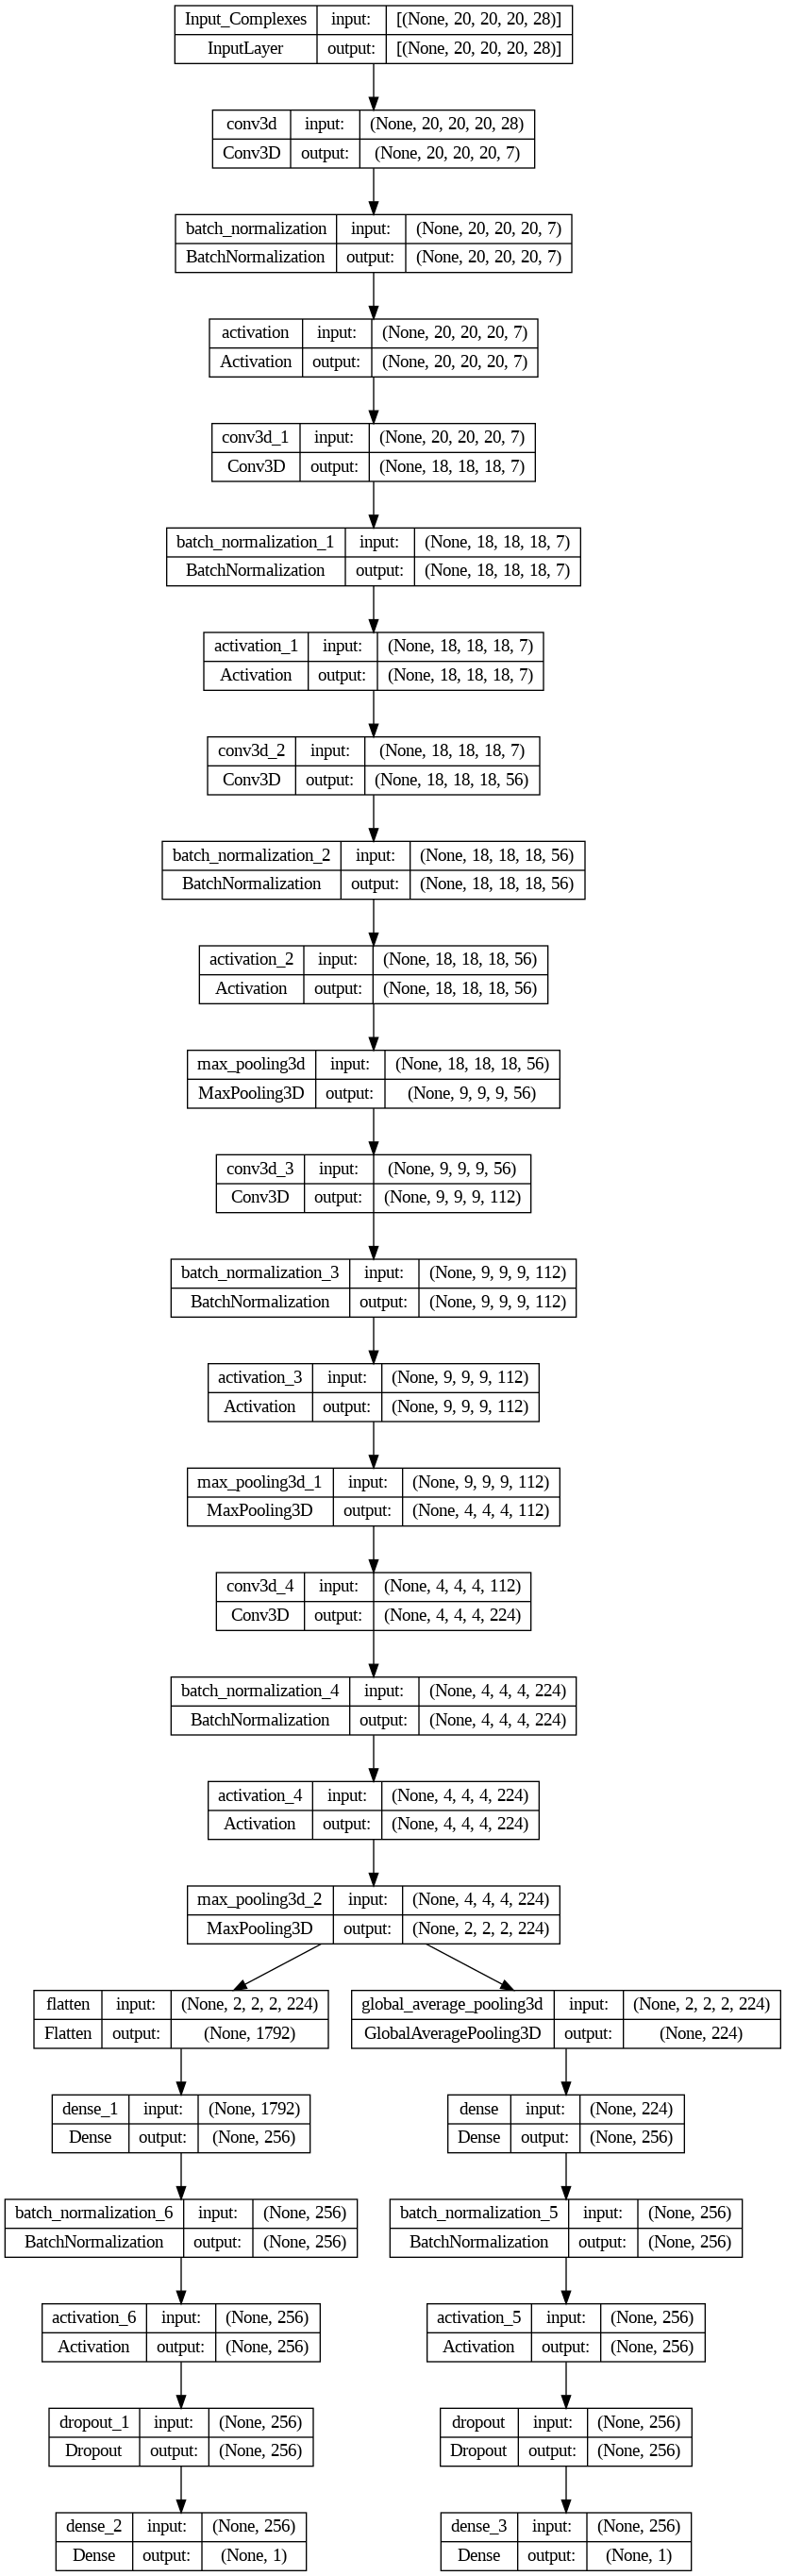

In [ ]:
testSFCNNModel = keras.models.load_model(sfcnn_save_path + '.keras')
# testSFCNNModel.summary()
plot_model(testSFCNNModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Create Comparision Reg Plot

In [ ]:
def run_plots(result_model):
  plot_reg(result_model[0], result_model[1])
  plot_class(result_model[2], result_model[3])

## Run training SFCNN

In [ ]:
resultSFCNN1 = exportVal(val_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, sfcnn_save_path, sfcnn_best_path, model_type1, csv_path1_100)

ValueError: File format not supported: filepath=./SFCNN/Save. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(./SFCNN/Save, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

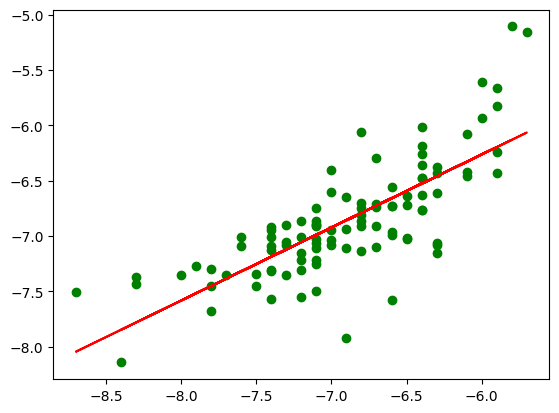

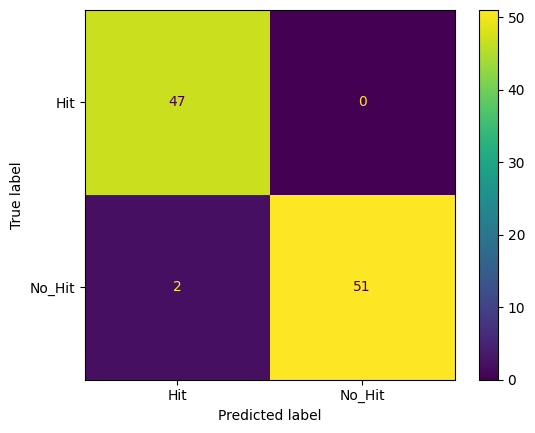

In [ ]:
# plot_reg(resultSFCNN1[0], resultSFCNN1[1])
# plot_class(resultSFCNN1[2], resultSFCNN1[3])
run_plots(resultSFCNN1)

In [ ]:
resultSFCNN2 = exportVal(test_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, sfcnn_save_path, sfcnn_best_path, model_type1, csv_path1_500)

----------------------- Start ValDataset ------------------------
Get dataset on batch 1
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 199ms/epoch - 199ms/step
Get dataset on batch 2
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 44ms/epoch - 44ms/step
Get dataset on batch 3
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 34ms/epoch - 34ms/step
Get dataset on batch 4
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 31ms/epoch - 31ms/step
Get dataset on batch 5
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 32ms/epoch - 32ms/step
Get dataset on batch 6
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 31ms/epoch - 31ms/step
Get dataset on batch 7
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 33ms/epoch - 33ms/step
Get dataset on batch 8
----------------------- Predict Va

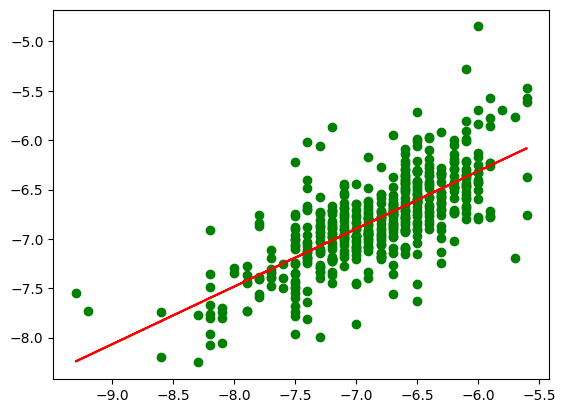

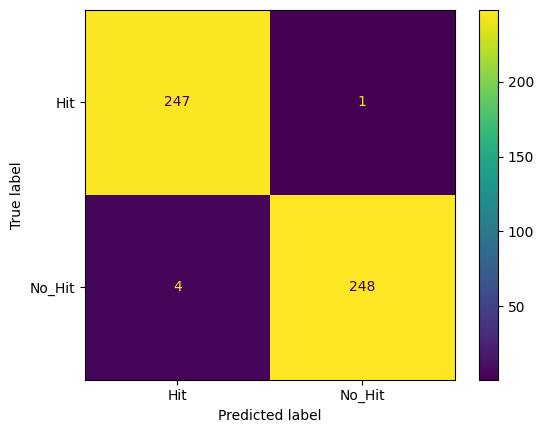

In [ ]:
# plot_reg(resultSFCNN2[0], resultSFCNN2[1])
# plot_class(resultSFCNN2[2], resultSFCNN2[3])
run_plots(resultSFCNN2)

In [ ]:
resultSFCNN3 = exportVal(last_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, sfcnn_save_path, sfcnn_best_path, model_type1, csv_path1_2000)

----------------------- Start ValDataset ------------------------
Get dataset on batch 1
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 188ms/epoch - 188ms/step
Get dataset on batch 2
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 33ms/epoch - 33ms/step
Get dataset on batch 3
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 33ms/epoch - 33ms/step
Get dataset on batch 4
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 34ms/epoch - 34ms/step
Get dataset on batch 5
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 41ms/epoch - 41ms/step
Get dataset on batch 6
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 32ms/epoch - 32ms/step
Get dataset on batch 7
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 31ms/epoch - 31ms/step
Get dataset on batch 8
----------------------- Predict Va

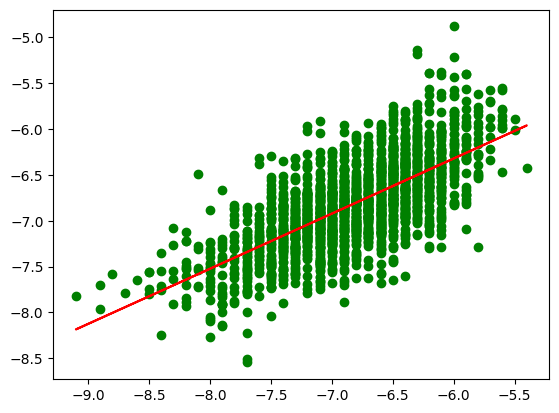

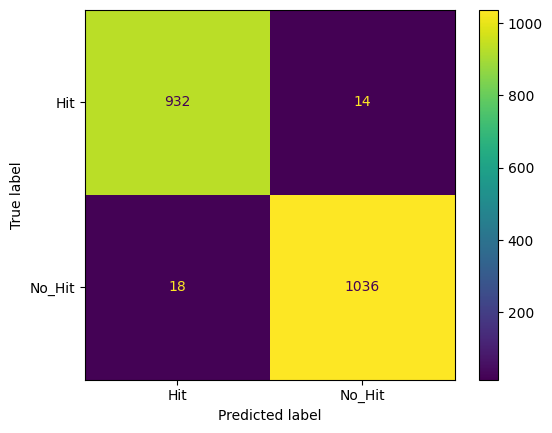

In [ ]:
# plot_reg(resultSFCNN3[0], resultSFCNN3[1])
# plot_class(resultSFCNN3[2], resultSFCNN3[3])
run_plots(resultSFCNN3)

In [ ]:
# model_test = keras.models.load_model(save_path1)
# model_test.summary()

## Run training 3DCNN

In [54]:
hyper_train(train_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, _3dcnn_save_path, _3dcnn_best_path, model_type2, hypers)

----------------------- Start TrainDataset ------------------------
=======================Batch 1==============================


/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 122 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Get dataset
----------------------- Train TrainDataset ------------------------



KeyboardInterrupt



In [ ]:
# exportVal(val_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, save_path2, best_path2, model_type2, csv_path3_100)

In [ ]:
result3DCNN4 = exportVal(val_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, test_save_path, test_best_path, model_type2, csv_path3_100)

----------------------- Start ValDataset ------------------------
Get dataset on batch 1
----------------------- Predict ValDataset ------------------------
1/1 - 3s - 3s/epoch - 3s/step
Get dataset on batch 2
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 234ms/epoch - 234ms/step
Get dataset on batch 3
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 230ms/epoch - 230ms/step
Get dataset on batch 4
----------------------- Predict ValDataset ------------------------
1/1 - 1s - 814ms/epoch - 814ms/step
++++++++++++++++++++++++++Regression++++++++++++++++++++++++++
Pearson Correlation Coefficient: 0.5597116986644518
P value: 1.4141332800216367e-09
Mean Absolute Error: 0.3867036
Root Mean Error: 0.5039069835041357
Correlation of Covariance: 0.29671362764751497
Spearman Rank Correlation Coefficient: 0.5373963022576347
P value: 8.176348511231536e-09
-------------------------------------------------------------
++++++++++++++++++++

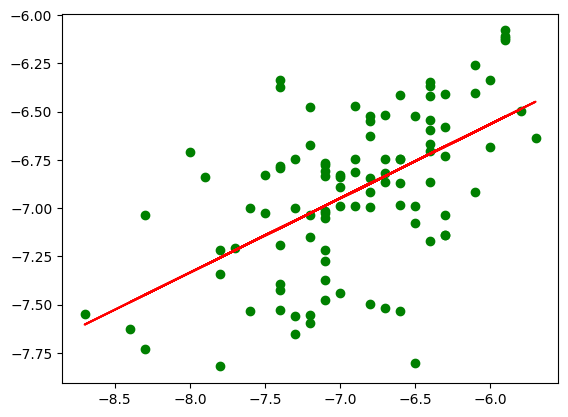

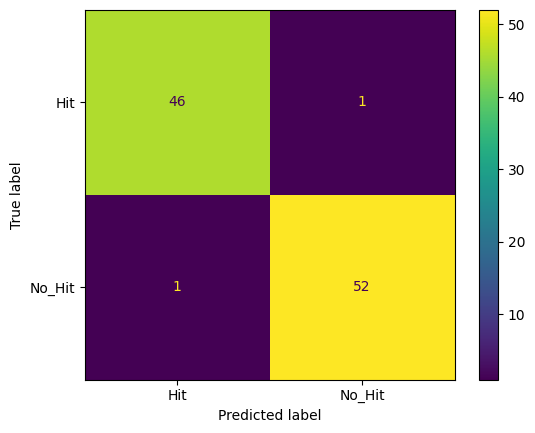

In [ ]:
run_plots(result3DCNN4)

In [ ]:
result3DCNN5 = exportVal(test_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, test_save_path, test_best_path, model_type2, csv_path3_500)

----------------------- Start ValDataset ------------------------
Get dataset on batch 1
----------------------- Predict ValDataset ------------------------


1/1 - 0s - 498ms/epoch - 498ms/step
Get dataset on batch 2
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 238ms/epoch - 238ms/step
Get dataset on batch 3
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 231ms/epoch - 231ms/step
Get dataset on batch 4
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 228ms/epoch - 228ms/step
Get dataset on batch 5
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 228ms/epoch - 228ms/step
Get dataset on batch 6
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 230ms/epoch - 230ms/step
Get dataset on batch 7
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 231ms/epoch - 231ms/step
Get dataset on batch 8
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 230ms/epoch - 230ms/step
Get dataset on batch 9
----------------------- Predict ValDataset ---------

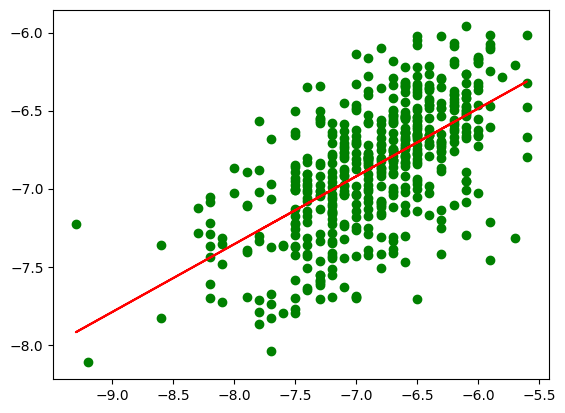

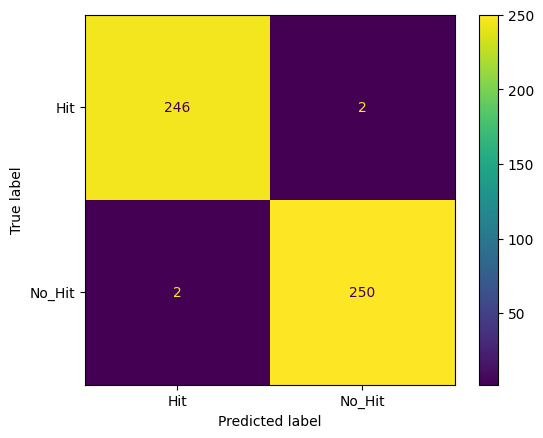

In [ ]:
run_plots(result3DCNN5)

In [ ]:
result3DCNN6 = exportVal(last_list_IDs, p_folder, l_folder, la_folder, batch_size, epochs, test_save_path, test_best_path, model_type2, csv_path3_2000)

----------------------- Start ValDataset ------------------------
Get dataset on batch 1
----------------------- Predict ValDataset ------------------------
1/1 - 1s - 511ms/epoch - 511ms/step
Get dataset on batch 2
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 236ms/epoch - 236ms/step
Get dataset on batch 3
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 233ms/epoch - 233ms/step
Get dataset on batch 4
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 227ms/epoch - 227ms/step
Get dataset on batch 5
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 230ms/epoch - 230ms/step
Get dataset on batch 6
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 226ms/epoch - 226ms/step
Get dataset on batch 7
----------------------- Predict ValDataset ------------------------
1/1 - 0s - 231ms/epoch - 231ms/step
Get dataset on batch 8
----------------------

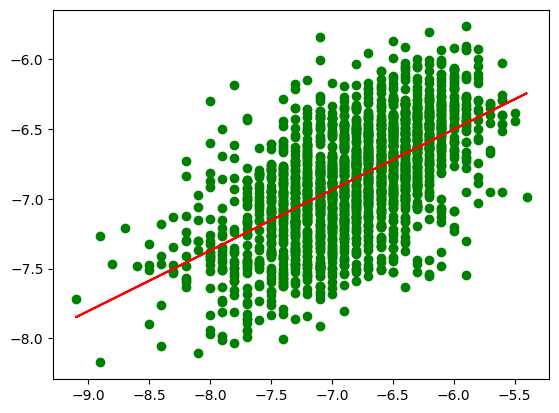

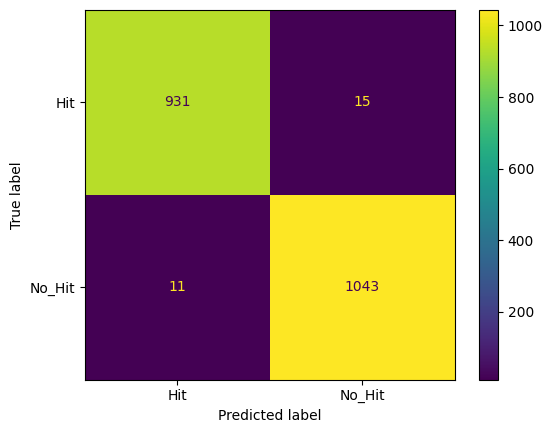

In [ ]:
run_plots(result3DCNN6)

In [ ]:
model_test = keras.models.load_model(test_save_path)
model_test.summary()

Model: "Embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Complexes (InputLayer)   [(None, 52, 52, 52,  0           []                               
                                 14)]                                                             
                                                                                                  
 conv3d_104 (Conv3D)            (None, 52, 52, 52,   480         ['Input_Complexes[0][0]']        
                                32)                                                               
                                                                                                  
 batch_normalization_129 (Batch  (None, 52, 52, 52,   128        ['conv3d_104[0][0]']             
 Normalization)                 32)                                                       